## N-Body problems

Many physical problems require the evaluation of all pairwise interactions of a large number of particles, so-called N-body problems. These problems arise in molecular dynamics, astrodynamics and electromagnetics among others. 

Their pairwise interactions can be expressed as:

\begin{equation}
f_i = \sum_{j=1}^n{P \left(\boldsymbol{x}_i, \boldsymbol{x}_j \right)w_j} \ \ \ \text{for } i=1,2,...,n 
\end{equation}

*  where subscripts $i$,  $j$ respectively denote *target* and *source*
*  $f_i$ can be a *potential* (or *force*) at target point $i$
*  $w_j$ is the *source weight* 
*  $\boldsymbol{x}_i, \boldsymbol{x}_j$ are the *spatial positions* of particles 
*  $P \left(\boldsymbol{x}_i, \boldsymbol{x}_j \right)$ is the *interaction kernel*. 

In order to evalute the potential $f_i$ at a target point $i$, we have to loop over each source particle $j$. Since there are $n$ target points $i$, this 'brute-force' approach costs $\mathcal{O} \left(n^2 \right)$ operations. 

One possible approach in this kind of problem is to define a few classes, say `Point` and `Particle` and then loop over the objects and perform the necessary point-to-point calculations.

In [1]:
import numpy as np
from numba import jit, njit
import matplotlib.pyplot as plt

In [2]:
pip install line_profiler

     |████████████████████████████████| 63 kB 1.8 MB/s 


In [3]:
%load_ext line_profiler

In [4]:
class Point():
    """    
    Arguments:
        domain: the domain of random generated coordinates x,y,z, 
                default=1.0
    
    Attributes:
        x, y, z: coordinates of the point
    """
    def __init__(self, domain=1.0):
        self.x = domain * np.random.random()
        self.y = domain * np.random.random()
        self.z = domain * np.random.random()
            
    def distance(self, other):
        return ((self.x - other.x)**2 + 
                (self.y - other.y)**2 + 
                (self.z - other.z)**2)**.5

In [5]:
class Particle(Point):
    """    
    Attributes:
        m: mass of the particle
        phi: the potential of the particle
    """
    
    def __init__(self, domain=1.0, m=1.0):
        Point.__init__(self, domain)
        self.m = m
        self.phi = 0.

Now we create a list of `n` random particles, define a function to calculate their interaction via direct summation and run!

In [6]:
n = 1000
particles = [Particle(m = 1 / n) for i in range(n)]

In [7]:
def direct_sum(particles):
    """
    Calculate the potential at each particle
    using direct summation method.

    Arguments:
        particles: the list of particles

    """
    for i, target in enumerate(particles):
        for source in (particles[:i] + particles[i+1:]):
            r = target.distance(source)
            target.phi += source.m / r

In [8]:
direct_sum(particles)

In [9]:
orig_time = %timeit -o direct_sum(particles)

1 loop, best of 5: 896 ms per loop


In [10]:
%lprun -f direct_sum direct_sum(particles)

## How do we use Numba on this problem?
Problem: Numba doesn't support jitting native Python classes.  There is a `jit_class` structure in Numba but it's still in early development.

But it's nice to have attributes for literate programming.

Solution: NumPy custom dtypes.

In [11]:
particle_dtype = np.dtype({'names':['x','y','z','m','phi'], 
                             'formats':[np.double, 
                                        np.double, 
                                        np.double, 
                                        np.double, 
                                        np.double]})

In [12]:
myarray = np.ones(3, dtype=particle_dtype)

In [13]:
myarray

array([(1., 1., 1., 1., 1.), (1., 1., 1., 1., 1.), (1., 1., 1., 1., 1.)],
      dtype=[('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('m', '<f8'), ('phi', '<f8')])

In [14]:
myarray[0]['x'] = 2.0

In [15]:
myarray

array([(2., 1., 1., 1., 1.), (1., 1., 1., 1., 1.), (1., 1., 1., 1., 1.)],
      dtype=[('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('m', '<f8'), ('phi', '<f8')])

### Exercise 1

Write a function `create_n_random_particles` that takes the arguments `n` (number of particles), `m` (mass of every particle) and a domain within to generate a random number (as in the class above).
It should create an array with `n` elements and `dtype=particle_dtype` and then return that array.

For each particle, the mass should be initialized to the value of `m` and the potential `phi` initialized to zero.

For the `x` component of a given particle `p`, you might do something like

```python
p['x'] = domain * np.random.random()
```

In [16]:
@njit
def create_n_random_particles(n, m, domain=1):
    '''
    Creates `n` particles with mass `m` with random coordinates
    between 0 and `domain`
    '''
    parts = np.zeros((n), dtype=particle_dtype)

    for p in parts:
        p['x'] = domain * np.random.random()
        p['y'] = domain * np.random.random()
        p['z'] = domain * np.random.random()
        p['m'] = m
        p['phi'] = 0.
    
    return parts   #parts is an array of particles

In [17]:
# test it
parts = create_n_random_particles(1000, .001, 1)

### Exercise 2

Write a JITted function `distance` to calculate the distance between two particles of dtype `particle_dtype`

Here's the `distance` method from the `Particle` class as a reference:

```python
def distance(self, other):
        return ((self.x - other.x)**2 + 
                (self.y - other.y)**2 + 
                (self.z - other.z)**2)**.5
```

In [20]:
@njit
def distance(part1, part2):
    '''calculate the distance between two particles'''
    return ((part1['x'] - part2['x'])**2 + 
            (part1['y'] - part2['y'])**2 + 
            (part1['z'] - part2['z'])**2)**.5

In [21]:
# test it
distance(parts[0], parts[1])

0.9620777449427435

### Exercise 3
Modify the original `direct_sum` function (copied below for reference) to instead work a Numpy array of particles.  Loop over each element in the array and calculate its total potential.

```python
def direct_sum(particles):
    """
    Calculate the potential at each particle
    using direct summation method.

    Arguments:
        particles: the list of particles

    """
    for i, target in enumerate(particles):
        for source in (particles[:i] + particles[i+1:]):
            r = target.distance(source)
            target.phi += source.m / r

In [22]:
@njit
def direct_sum_np(particles):
    indexes = np.arange(len(particles))
    for i, target in enumerate(particles):
        for source in particles[indexes != i]:
            r = distance(target, source)
            target['phi'] += source['m'] / r

## Graph

In [24]:
from tqdm import tqdm
t_arr = np.zeros(11)
t_arr_np = np.zeros(11)
size_arr = [2**i for i in range(1,12)]
for i, size in tqdm(enumerate(size_arr)):
    parts = [Particle(m=1./size) for i in range(size)]
    parts_np = create_n_random_particles(size, 1./size, 1)
    
    time = %timeit -o -q -r 5 -n 5 direct_sum(parts)
    t_arr[i] = time.best
    
    time = %timeit -o -q -r 5 -n 5 direct_sum_np(parts_np)
    t_arr_np[i] = time.best

11it [02:09, 11.79s/it]


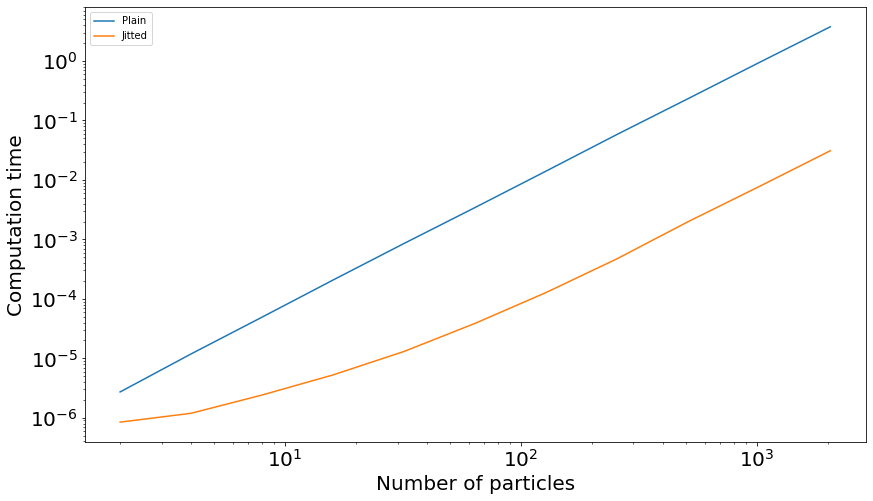

In [31]:
plt.figure(figsize=(14, 8))
plt.plot(size_arr, t_arr,    label='Plain' )
plt.plot(size_arr, t_arr_np, label='Jitted'  )
plt.legend()
plt.xlabel('Number of particles',fontsize=20)
plt.ylabel('Computation time',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xscale('log')
plt.yscale('log')
plt.show()

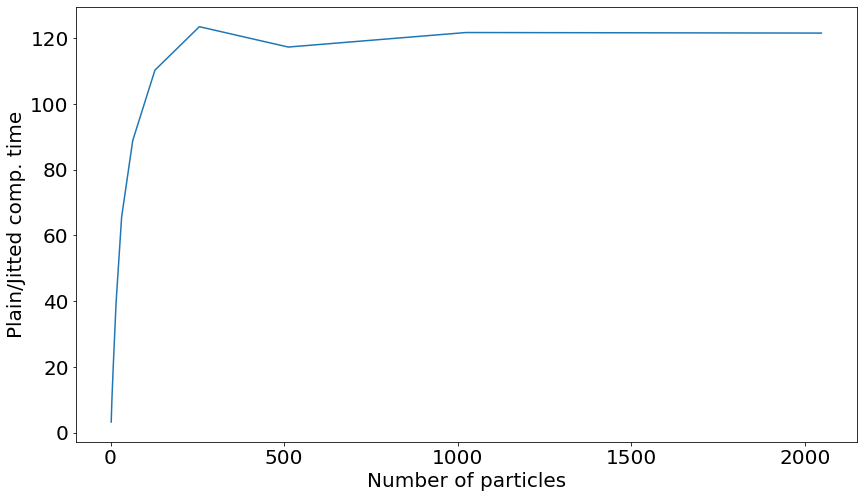

In [30]:
plt.figure(figsize=(14, 8))
plt.plot(size_arr, t_arr/t_arr_np,    label='Plain/Jitted' )
plt.xlabel('Number of particles',fontsize=20)
plt.ylabel('Plain/Jitted comp. time',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()